# Horizontally integrate multiple scRNA-seq samples
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script 

In [2]:
# Python packages
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc

#import scib
import scvi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/flax/struct.py:132: FutureWarni

In [60]:
# List h5ads to integrate
results_paths = [
    "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control",
    "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/21Oct23/A2_control",
]

In [61]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    h5ad_paths += glob.glob(os.path.join(results_path, "*", "rna", "annotate", "*.h5ad"))
len(h5ad_paths), h5ad_paths

(10,
 ['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo38/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo29/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo14/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo22/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo3/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo1/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/21Oct23/A2_control/dm45a/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/21Oct23/A2_control/dm35a/

In [5]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:
    sample = h5ad_path.split("/")[-4]
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata_cp = sc.AnnData(adata.layers["soupX_counts"].copy(), obs=adata.obs.copy(), var=adata.var.copy())
    adata_list.append(adata_cp)
    samples.append(sample)
samples

['mo38', 'mo29', 'mo14', 'mo22', 'mo3', 'mo1']

In [6]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

sample
mo38    6092
mo22    4512
mo1     3178
mo3     2834
mo14    2451
mo29    1485
Name: count, dtype: int64

In [7]:
# What do cell identities look like
adata_concat.obs["manual_cellid_annotation"].value_counts()

manual_cellid_annotation
SC.EC                    6945
SC.beta                  6791
SC.alpha                 5426
endocrine_progenitor      688
SC.delta                  452
proliferating_alpha       183
pancreatic_progenitor      67
Name: count, dtype: int64

In [8]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_concat.obs["sample"], adata_concat.obs["manual_cellid_annotation"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

manual_cellid_annotation,SC.EC,SC.alpha,SC.beta,SC.delta,endocrine_progenitor,pancreatic_progenitor,proliferating_alpha
sample,,,,,,,
mo38,0.274130,0.396093,0.277085,0.006894,0.026592,0.008372,0.010834
mo29,0.297643,0.301684,0.334007,0.030303,0.036364,0.000000,0.000000
mo14,0.394941,0.134231,0.361893,0.077519,0.023256,0.000000,0.008160
mo22,0.373449,0.218307,0.326463,0.009752,0.055629,0.003546,0.012855
mo3,0.375088,0.220536,0.346507,0.023289,0.034580,0.000000,0.000000
mo1,0.351479,0.196979,0.398049,0.020453,0.020768,0.000000,0.012272


<Axes: xlabel='sample'>

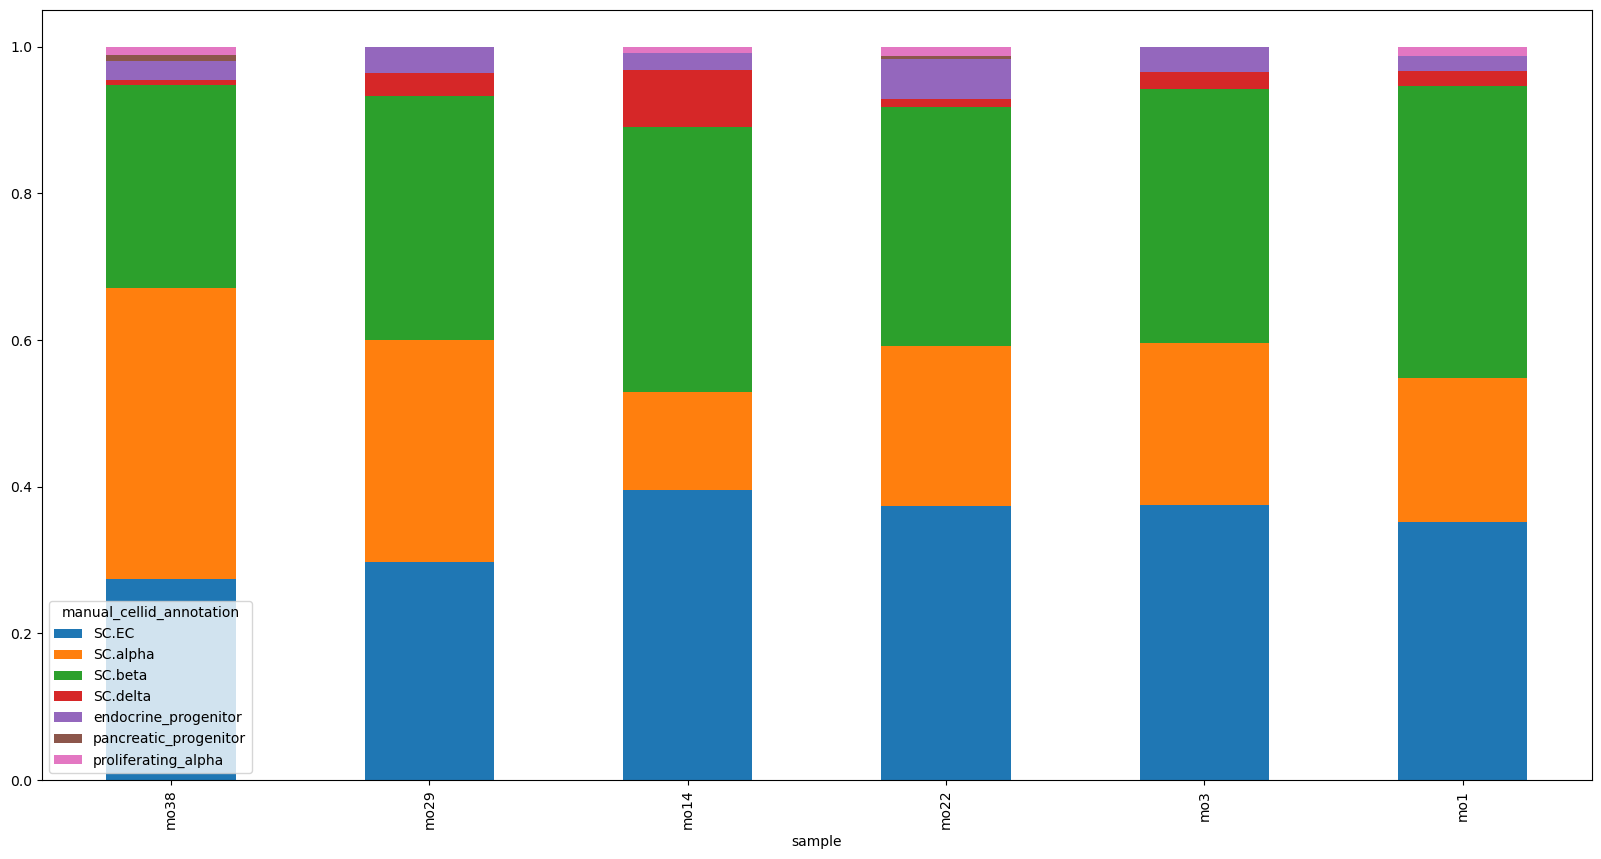

In [9]:
# Make a pretty bar plot with x-axis showing sample and y-axis showing manual_cellid_annotation
cross_tab_norm.plot.bar(stacked=True, figsize=(20, 10))

# Marker genes

In [10]:
# Grab marker genes
marker_genes_df = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/18Oct23/SC.islet.marker_genes.csv")
marker_genes_dict = marker_genes_df.groupby("cell_id")["gene"].apply(list).to_dict()

# Check markers against adata.var
marker_genes_in_data = dict()
for ct, markers in marker_genes_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in adata_concat.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

# Remove any keys with lists of length 0
marker_genes_in_data = {k: v for k, v in marker_genes_in_data.items() if len(v) > 0}

# Output
marker_genes_in_data

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST'],
 'endocrine_progenitor': ['ZEB2', 'FEV']}

In [11]:
# Save counts in adata_concat.raw
adata_concat.raw = adata_concat.copy()

In [12]:
# Save counts in adata_concat.layers["counts"]
adata_concat.layers["counts"] = adata_concat.X.copy()

In [13]:
# Set paramaters
batch_key = "sample"
n_comps = 50
n_neighbors = 30
umap_min_dist = 0.3
leiden_resolution = 1
random_state = 1234

# Unintegrated log1p normalized data

In [14]:
# Create a copy for unintegrated log1p
adata_log1p = adata_concat.copy()
adata_log1p

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [15]:
# Normalize data based on all cells
sc.pp.normalize_total(adata_log1p)
sc.pp.log1p(adata_log1p)
adata_log1p.layers["logcounts"] = adata_log1p.X.copy()

In [16]:
# Select highly variable genes for PCA
sc.pp.highly_variable_genes(adata_log1p)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
# Run PCA
sc.tl.pca(adata_log1p, n_comps=n_comps, svd_solver="arpack", use_highly_variable=True, zero_center=True, dtype="float32", copy=False, random_state=random_state)

In [18]:
# Find neighbors
sc.pp.neighbors(adata_log1p, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [19]:
# Run UMAP
sc.tl.umap(adata_log1p, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [20]:
# Cluster unintegrated data
sc.tl.leiden(adata_log1p, key_added=f"log1p_unintegrated_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [21]:
"""
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_log1p,
    label_key="manual_cellid_annotation",
    cluster_key="log1p_unintegrated_leiden_optimal",
    use_rep="X_pca",
)
"""

'\n# Get a optimal clustering\nscib.me.cluster_optimal_resolution(\n    adata=adata_log1p,\n    label_key="manual_cellid_annotation",\n    cluster_key="log1p_unintegrated_leiden_optimal",\n    use_rep="X_pca",\n)\n'

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/m

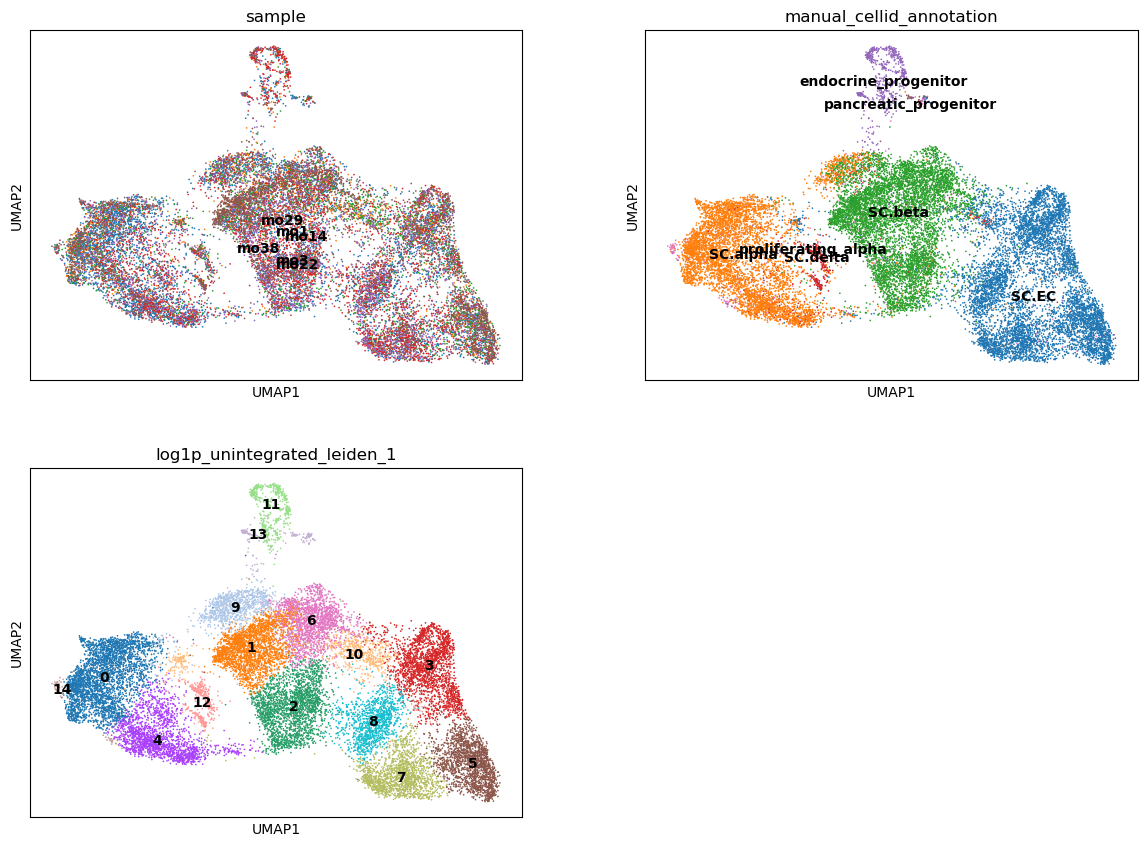

In [23]:
# Plot with sample colors
sc.pl.umap(
    adata_log1p, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"log1p_unintegrated_leiden_{leiden_resolution}", 
        #"log1p_unintegrated_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# scVI

In [33]:
# Make a copy for integrated
adata_scvi = adata_concat.copy()
adata_scvi

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [34]:
# Set-up the anndata
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="sample")
adata_scvi

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [40]:
# Create the model
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [41]:
# Check the set-up
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 20552 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15112 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    mo38    │          0          │
│                     │    mo29    │          1          │
│                     │    mo14    │          2          │
│                     │    mo22    │          3          │
│                     │    mo3     │          4          │
│                     │    mo1     │          5          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [43]:
# Train the model
model_scvi.train(early_stopping=True)

/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
LOCAL_RANK: 0 - CU

Epoch 35/389:   9%|▊         | 34/389 [01:09<12:08,  2.05s/it, v_num=1, train_loss_step=7.19e+3, train_loss_epoch=7.75e+3]

In [49]:
# Grab the latent representation
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

In [53]:
# Find neighbors
sc.pp.neighbors(adata_scvi, use_rep="X_scVI", n_neighbors=n_neighbors, random_state=random_state) #, key_added="unintegrated")

In [54]:
# Run UMAP
sc.tl.umap(adata_scvi, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [55]:
# Cluster unintegrated data
sc.tl.leiden(adata_scvi, key_added=f"scvi_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [32]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_scvi,
    label_key="manual_cellid_annotation",
    cluster_key="scvi_leiden_optimal",
    use_rep="X_scVI",
)

Compute neighbors on rep X_scVI
resolution: 0.1, nmi: 0.7019819807142961
resolution: 0.2, nmi: 0.6140150306415552
resolution: 0.3, nmi: 0.5687392990329346
resolution: 0.4, nmi: 0.554238354169193
resolution: 0.5, nmi: 0.5196755693230047
resolution: 0.6, nmi: 0.5369552430459951
resolution: 0.7, nmi: 0.5346221442705162
resolution: 0.8, nmi: 0.522078292831628
resolution: 0.9, nmi: 0.508496048420911
resolution: 1.0, nmi: 0.4972278021259313
resolution: 1.1, nmi: 0.5016264861621959
resolution: 1.2, nmi: 0.48825335485845983
resolution: 1.3, nmi: 0.48482914557741413
resolution: 1.4, nmi: 0.4814098566032492
resolution: 1.5, nmi: 0.4729583731977728
resolution: 1.6, nmi: 0.4662883102107227
resolution: 1.7, nmi: 0.4646656418843776
resolution: 1.8, nmi: 0.462796164032899
resolution: 1.9, nmi: 0.46226446076304584
resolution: 2.0, nmi: 0.45379039215943284
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.1
optimal score: 0.7019819807142961


/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/m

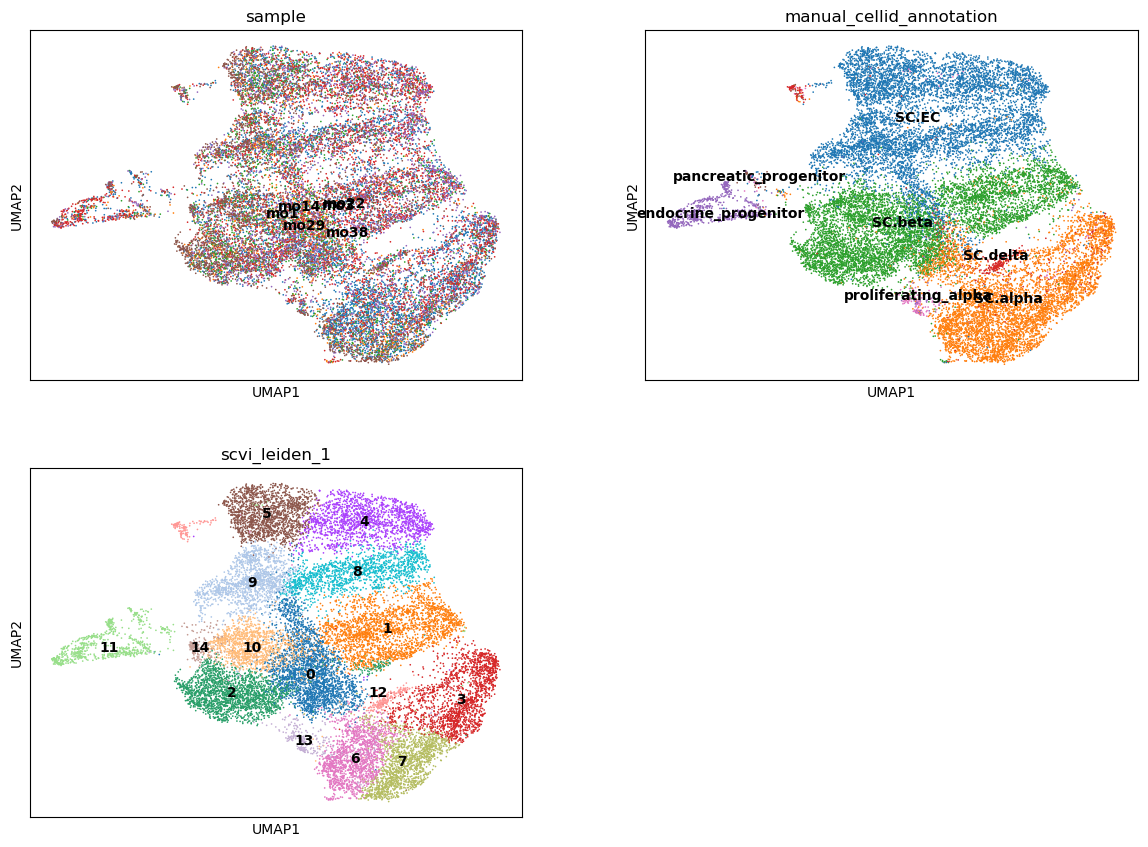

In [56]:
# Plot with sample colors
sc.pl.umap(
    adata_scvi, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"scvi_leiden_{leiden_resolution}", 
        #"scvi_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# scANVI

In [57]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi, labels_key="manual_cellid_annotation", unlabeled_category="unlabelled"
)
print(model_scanvi)
model_scanvi.view_anndata_setup()

ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Not Trained
Model's adata is minified?: False

Anndata setup with scvi-tools version 1.0.4.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'manual_cellid_annotation',
│   'unlabeled_category': 'unlabelled',
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 20552 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 15112 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    mo38    │          0          │
│                     │    mo29    │          1          │
│                     │    mo14    │          2          │
│                     │    mo22    │          3          │
│                     │    mo3     │          4          │
│                     │    mo1     │          5          │
└─────────────────────┴────────────┴─────────────────────┘

                                 labels State Registry                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃            Source Location            ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['manual_cellid_annotation'] │         SC.EC         │          0          │
│                                       │       SC.alpha        │          1          │
│                                       │        SC.beta        │          2          │
│                                       │       SC.delta        │          3          │
│                                       │ endocrine_progenitor  │          4          │
│                                       │ pancreatic_progenitor │          5          │
│                                       │  proliferating_alpha  │          6          │
│                                       │      unlabelled       │          7          │
└───────────────────────────────────────┴───────────────────────┴─────────────────────┘

In [58]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(max_epochs_scvi / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scanvi)

INFO     Training for 10 epochs.                                                                                   


/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/integrate-py ...
  rank_zero_warn(
LOCAL_RANK: 0 - CU

Epoch 10/10: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it, v_num=1, train_loss_step=7.89e+3, train_loss_epoch=7.79e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it, v_num=1, train_loss_step=7.89e+3, train_loss_epoch=7.79e+3]


/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/integrate-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/m

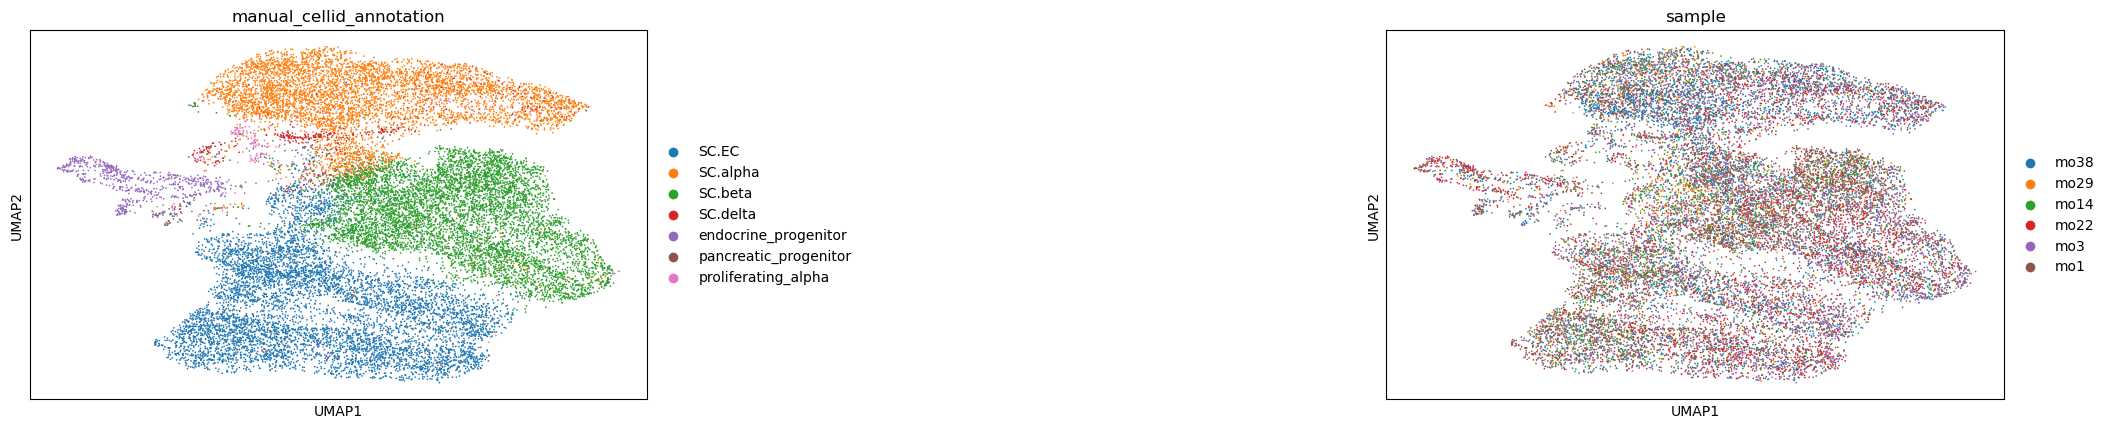

In [59]:
adata_scanvi = adata_scvi.copy()
adata_scanvi.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_scanvi, use_rep="X_scANVI")
sc.tl.umap(adata_scanvi)
sc.pl.umap(adata_scanvi, color=["manual_cellid_annotation", batch_key], wspace=1)

# DONE!

---